<a href="https://colab.research.google.com/github/zwe-htet-paing/notebooks/blob/main/Deep_Learning_with_PyTorch_Object_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro Task, Object Localization 

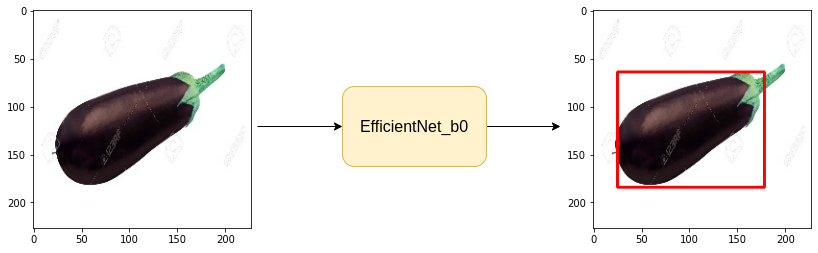

In [ ]:
# install libraries/packages/modules 

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-oqaw8z45
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-oqaw8z45
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

fatal: destination path 'object-localization-dataset' already exists and is not an empty directory.


In [ ]:
import pandas as pd 
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [ ]:
CSV_FILE = '/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset/'

DEVICE = 'cuda'

BATCH_SIZE = 16
IMG_SIZE = 140

LR = 0.001
EPOCHS = 40
MODEL_NAME = 'efficientnet_b0'

NUM_COL = 4

In [ ]:
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

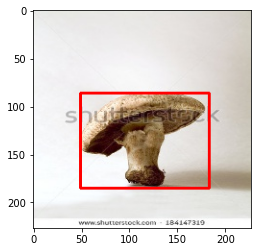

In [ ]:
row = df.iloc[2]
img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

pt1 = (row.xmin, row.ymin)
pt2 = (row.xmax, row.ymax)
bnd_img = cv2.rectangle(img, pt1, pt2, (255, 0, 0), 2)

plt.imshow(bnd_img)

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state = 42)

# Augmentations

In [ ]:
import albumentations as A

In [ ]:
train_augs = A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5),
      A.Rotate()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields = ['class_labels']))

valid_augs = A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      
], bbox_params=A.BboxParams(format='pascal_voc', label_fields = ['class_labels']))

# Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

class ObjLocDataset(Dataset):

  def __init__(self, df, augmentations = None):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    xmin = row.xmin
    ymin = row.ymin
    xmax = row.xmax
    ymax = row.ymax

    bbox = [[xmin, ymin, xmax, ymax]]

    img_path = DATA_DIR + row.img_path
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if self.augmentations:
      data = self.augmentations(image=img, bboxes=bbox, class_labels=[None])
      img = data['image']
      bbox = data['bboxes'][0]

    img = torch.from_numpy(img).permute(2, 0, 1) / 255.0 # (h, w, c) --> (c, h, w)
    bbox = torch.Tensor(bbox)

    return img, bbox

In [ ]:
trainset = ObjLocDataset(train_df, train_augs)
validset = ObjLocDataset(valid_df, valid_augs)

In [ ]:
print(f'Total examples in trainset: {len(trainset)}')
print(f'Total examples in validset: {len(validset)}')

Total examples in trainset: 148
Total examples in validset: 38


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


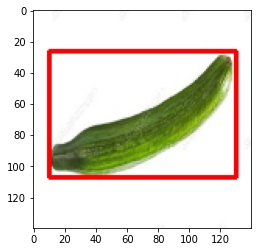

In [ ]:
img, bbox = trainset[6]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [ ]:
for images, bboxes in trainloader:
  break;


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [ ]:
from torch import nn 
import timm

In [ ]:
class ObjLocModel(nn.Module):

  def __init__(self):
    super(ObjLocModel, self).__init__()

    self.backbone = timm.create_model(MODEL_NAME, pretrained=True, num_classes=4)

  def forward(self, images, gt_bboxes=None):
    bboxes = self.backbone(images)

    if gt_bboxes != None:
      loss = nn.MSELoss()(bboxes, gt_bboxes)
      return bboxes, loss

    return bboxes

In [ ]:
model = ObjLocModel()
model.to(DEVICE);

In [ ]:
random_img = torch.rand(1, 3, 140, 140).to(DEVICE)
model(random_img).shape

torch.Size([1, 4])

# Create Train and Eval Function

In [ ]:
def train_fn(model, dataloader, optimizer):

  total_loss = 0.0
  model.train() # Dropout ON

  for data in tqdm(dataloader):

    images, gt_bboxes = data
    images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

    bboxes, loss = model(images, gt_bboxes)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [ ]:
def eval_fn(model, dataloader):

  total_loss = 0.0
  model.eval() # Dropout OFF

  with torch.no_grad():
    for data in tqdm(dataloader):

      images, gt_bboxes = data
      images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

      bboxes, loss = model(images, gt_bboxes)

      total_loss += loss.item()

    return total_loss / len(dataloader)

#Training Loop

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
best_val_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(model, trainloader, optimizer)
  valid_loss = eval_fn(model, validloader)

  if valid_loss < best_val_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print('Saved best model weights')
    best_val_loss = valid_loss

  print(f"Epochs: {i+1} | Train_Loss: {train_loss} | Valid_Loss: {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved best model weights
Epochs: 1 | Train_Loss: 5313.492822265625 | Valid_Loss: 2781.09912109375


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 2 | Train_Loss: 2044.2883056640626 | Valid_Loss: 3149.0364583333335


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved best model weights
Epochs: 3 | Train_Loss: 1250.1978088378905 | Valid_Loss: 261.45627848307294


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved best model weights
Epochs: 4 | Train_Loss: 765.956103515625 | Valid_Loss: 204.86453247070312


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 5 | Train_Loss: 508.9096252441406 | Valid_Loss: 214.6167755126953


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved best model weights
Epochs: 6 | Train_Loss: 373.61487884521483 | Valid_Loss: 133.1515655517578


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved best model weights
Epochs: 7 | Train_Loss: 275.2454086303711 | Valid_Loss: 128.88187154134116


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 8 | Train_Loss: 223.70317535400392 | Valid_Loss: 145.8770548502604


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 9 | Train_Loss: 182.67256851196288 | Valid_Loss: 143.90279134114584


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 10 | Train_Loss: 138.48825759887694 | Valid_Loss: 143.16412353515625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 11 | Train_Loss: 113.90559043884278 | Valid_Loss: 147.02086893717447


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 12 | Train_Loss: 112.30837631225586 | Valid_Loss: 139.97704060872397


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved best model weights
Epochs: 13 | Train_Loss: 99.90126037597656 | Valid_Loss: 112.38006591796875


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved best model weights
Epochs: 14 | Train_Loss: 107.99792861938477 | Valid_Loss: 106.79793802897136


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved best model weights
Epochs: 15 | Train_Loss: 78.81667289733886 | Valid_Loss: 101.34182993570964


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 16 | Train_Loss: 78.07559356689453 | Valid_Loss: 117.50764465332031


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved best model weights
Epochs: 17 | Train_Loss: 69.0158317565918 | Valid_Loss: 87.10440826416016


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 18 | Train_Loss: 101.24806442260743 | Valid_Loss: 95.45593516031902


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved best model weights
Epochs: 19 | Train_Loss: 67.52099723815918 | Valid_Loss: 73.56927744547527


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 20 | Train_Loss: 69.50615921020508 | Valid_Loss: 115.53946940104167


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 21 | Train_Loss: 67.98831062316894 | Valid_Loss: 74.41400655110677


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved best model weights
Epochs: 22 | Train_Loss: 57.14698028564453 | Valid_Loss: 66.53269958496094


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved best model weights
Epochs: 23 | Train_Loss: 57.40985164642334 | Valid_Loss: 61.87983830769857


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved best model weights
Epochs: 24 | Train_Loss: 40.6243034362793 | Valid_Loss: 53.1564572652181


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 25 | Train_Loss: 56.828229904174805 | Valid_Loss: 66.21589787801106


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 26 | Train_Loss: 68.7824607849121 | Valid_Loss: 69.01623026529948


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 27 | Train_Loss: 49.42444496154785 | Valid_Loss: 73.6019999186198


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 28 | Train_Loss: 52.78993396759033 | Valid_Loss: 82.53448104858398


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 29 | Train_Loss: 63.769425582885745 | Valid_Loss: 58.52879842122396


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 30 | Train_Loss: 45.157263374328615 | Valid_Loss: 76.80449930826823


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 31 | Train_Loss: 48.77260494232178 | Valid_Loss: 67.04356638590495


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 32 | Train_Loss: 48.12375373840332 | Valid_Loss: 64.43584569295247


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 33 | Train_Loss: 46.53390350341797 | Valid_Loss: 71.8032735188802


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 34 | Train_Loss: 44.62748260498047 | Valid_Loss: 79.75603993733723


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 35 | Train_Loss: 50.80141716003418 | Valid_Loss: 81.75821177164714


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved best model weights
Epochs: 36 | Train_Loss: 50.8693229675293 | Valid_Loss: 52.84230041503906


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Saved best model weights
Epochs: 37 | Train_Loss: 43.991517066955566 | Valid_Loss: 50.09260686238607


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 38 | Train_Loss: 48.925439071655276 | Valid_Loss: 83.07499186197917


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 39 | Train_Loss: 39.15005340576172 | Valid_Loss: 87.52337265014648


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 40 | Train_Loss: 38.66635017395019 | Valid_Loss: 68.8914368947347


#Inference

In [ ]:
import utils

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


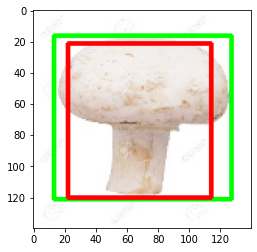

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():

  image, gt_bbox = validset[1] # (c, h, w)
  image = image.unsqueeze(0).to(DEVICE) # (bs, c, h, w)
  out_bbox = model(image)

  utils.compare_plots(image, gt_bbox, out_bbox)
